- Author: Jaehyuk Heo
- Source: https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2

import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

import torch

import os

In [2]:
# !mkdir checkpoints
# !wget -c https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r101_fpn_1x_coco/retinanet_r101_fpn_1x_coco_20200130-7a93545f.pth \
#       -O checkpoints/retinanet_r101_fpn_1x_coco_20200130-7a93545f.pth

In [3]:
class Config:
    config = 'mmdetection/configs/retinanet/retinanet_r101_fpn_1x_coco.py'
    checkpoint = 'checkpoints/retinanet_r101_fpn_1x_coco_20200130-7a93545f.pth'

    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    
args = Config()

In [123]:
config = mmcv.Config.fromfile(args.config)

In [35]:
print(config.pretty_text)

model = dict(
    type='RetinaNet',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        start_level=1,
        add_extra_convs='on_input',
        num_outs=5),
    bbox_head=dict(
        type='RetinaHead',
        num_classes=80,
        in_channels=256,
        stacked_convs=4,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            octave_base_scale=4,
            scales_per_octave=3,
            ratios=[0.5, 1.0, 2.0],
            strides=[8, 16, 32, 64, 128]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
       

In [39]:
config.model.pretrained = None

# load model and pretrained weights
model = build_detector(config.model)
checkpoint = load_checkpoint(model, args.checkpoint, map_location=args.device)

# set classes and config
model.CLASSES = checkpoint['meta']['CLASSES']
model.cfg = config

# set device and convert model into eval mode
model.to(args.device)
model.eval()

print('complete')

load checkpoint from local path: checkpoints/retinanet_r101_fpn_1x_coco_20200130-7a93545f.pth
complete


# Inference

In [40]:
img = 'mmdetection/demo/demo.jpg'
result = inference_detector(model, img) # 각 클래스별 predicted result (x1, y1, x2, y2, score)

/projects/projects/keras2torch/Computer_Vision/Object_Detection_with_RetinaNet/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


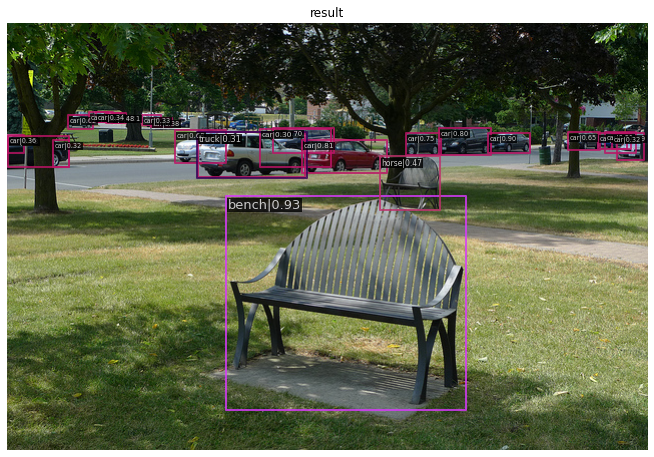

In [109]:
show_result_pyplot(model, img, result, score_thr=0.3)

# Fine-tuning

In [14]:
from mmdet.datasets import build_dataset, build_dataloader
from mmdet.models import build_detector
from mmdet.apis import train_detector, set_random_seed, single_gpu_test

## Config

In [5]:
def change_dir(config):
    config.data_root = '/datasets/MSCOCO/'

    config.data.train.ann_file = '/datasets/MSCOCO/annotations/instances_train2017.json'
    config.data.train.img_prefix = '/datasets/MSCOCO/images/train2017/'

    config.data.val.ann_file = '/datasets/MSCOCO/annotations/instances_val2017.json'
    config.data.val.img_prefix = '/datasets/MSCOCO/images/val2017/'

    config.data.test.ann_file = '/datasets/MSCOCO/annotations/instances_val2017.json'
    config.data.test.img_prefix = '/datasets/MSCOCO/images/val2017/'

    return config

In [47]:
config = mmcv.Config.fromfile(args.config)

In [48]:
config = change_dir(config)
config.runner = {'type': 'IterBasedRunner', 'max_iters': 10}


# set seed and device number
config.seed = 0
config.gpu_ids = [0]

In [40]:
# load pretrained weights
config.load_from = args.checkpoint

# set log directory
config.work_dir = './retinanet_mmdet_logs'

## Dataset

In [8]:
datasets = [build_dataset(config.data.train)]

loading annotations into memory...
Done (t=14.17s)
creating index...
index created!


In [9]:
print(datasets[0])


CocoDataset Train dataset with number of images 117266, and instance counts: 
+---------------------+--------+-----------------+-------+--------------------+-------+--------------------+-------+-------------------+-------+
| category            | count  | category        | count | category           | count | category           | count | category          | count |
+---------------------+--------+-----------------+-------+--------------------+-------+--------------------+-------+-------------------+-------+
| 0 [person]          | 257249 | 1 [bicycle]     | 7056  | 2 [car]            | 43532 | 3 [motorcycle]     | 8654  | 4 [airplane]      | 5129  |
| 5 [bus]             | 6061   | 6 [train]       | 4570  | 7 [truck]          | 9970  | 8 [boat]           | 10575 | 9 [traffic light] | 12841 |
| 10 [fire hydrant]   | 1865   | 11 [stop sign]  | 1983  | 12 [parking meter] | 1283  | 13 [bench]         | 9820  | 14 [bird]         | 10537 |
| 15 [cat]            | 4766   | 16 [dog]        | 

## Build a Model

In [10]:
model = build_detector(config.model)
model.CLASSES = datasets[0].CLASSES

## Training

In [11]:
mmcv.mkdir_or_exist(os.path.abspath(config.work_dir))
train_detector(model, datasets, config, distributed=False, validate=False)

2022-03-22 06:58:40,736 - mmdet - INFO - load checkpoint from local path: checkpoints/retinanet_r101_fpn_1x_coco_20200130-7a93545f.pth
2022-03-22 06:58:40,893 - mmdet - INFO - Start running, host: root@keras2torch, work_dir: /projects/projects/keras2torch/Computer_Vision/Object_Detection_with_RetinaNet/retinanet_mmdet_logs
2022-03-22 06:58:40,894 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
 -------------------- 
after_tr

## Evaluation

In [3]:
!python mmdetection/tools/test.py \
    mmdetection/configs/retinanet/retinanet_r101_fpn_1x_coco.py \
    retinanet_mmdet_logs/latest.pth \
    --eval bbox 

/projects/projects/keras2torch/Computer_Vision/Object_Detection_with_RetinaNet/mmdetection/mmdet/utils/setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/projects/projects/keras2torch/Computer_Vision/Object_Detection_with_RetinaNet/mmdetection/mmdet/utils/setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
load checkpoint from local path: retinanet_mmdet_logs/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 500

## Swin Transformer Results

In [8]:
# !wget -c https://github.com/SwinTransformer/storage/releases/download/v1.0.2/cascade_mask_rcnn_swin_base_patch4_window7.pth \
#       -O checkpoints/cascade_mask_rcnn_swin_base_patch4_window7.pth

In [4]:
!python ./mmdetection/tools/test.py \
    ./mmdetection/configs/swin/cascade_mask_rcnn_swin_base_patch4_window7_mstrain_480-800_giou_4conv1f_adamw_3x_coco.py \
    checkpoints/cascade_mask_rcnn_swin_base_patch4_window7.pth \
    --eval bbox 

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
load checkpoint from local path: checkpoints/cascade_mask_rcnn_swin_base_patch4_window7.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5000/5000, 6.4 task/s, elapsed: 775s, ETA:     0s
Evaluating bbox...
Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=35.62s).
Accumulating evaluation results...
DONE (t=5.02s).

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.51912
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.70475
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.56393
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.35390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.55196
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.67359
 Average Recall

In [7]:
args.config = './Swin-Transformer-Object-Detection/configs/swin/cascade_mask_rcnn_swin_base_patch4_window7_mstrain_480-800_giou_4conv1f_adamw_3x_coco.py'
config = mmcv.Config.fromfile(args.config)

In [8]:
args.checkpoint = './checkpoints/cascade_mask_rcnn_swin_base_patch4_window7.pth'
config.model.pretrained = None

# load model and pretrained weights
model = build_detector(config.model)
checkpoint = load_checkpoint(model, args.checkpoint, map_location=args.device)

# set classes and config
model.CLASSES = checkpoint['meta']['CLASSES']
model.cfg = config

# set device and convert model into eval mode
model.to(args.device)
model.eval()

print('complete')

load checkpoint from local path: ./checkpoints/cascade_mask_rcnn_swin_base_patch4_window7.pth
complete


In [9]:
img = 'mmdetection/demo/demo.jpg'
result = inference_detector(model, img) # 각 클래스별 predicted result (x1, y1, x2, y2, score)

/projects/projects/keras2torch/Computer_Vision/Object_Detection_with_RetinaNet/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


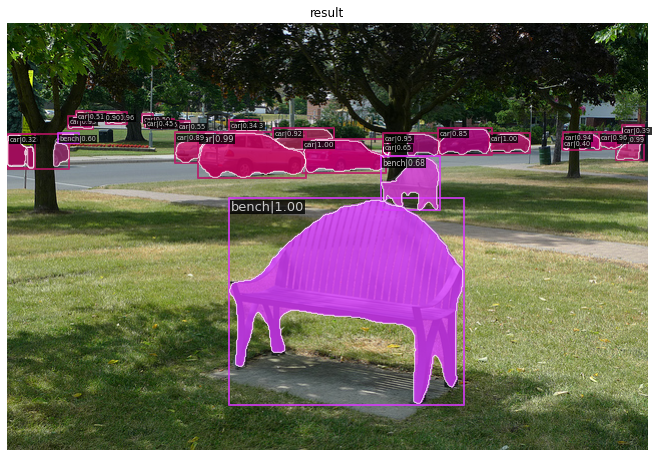

In [10]:
show_result_pyplot(model, img, result, score_thr=0.3)


# Dyhead

In [5]:
args.config = './mmdetection/configs/swin/cascade_mask_rcnn_swin_base_patch4_window7_mstrain_480-800_giou_4conv1f_adamw_3x_coco.py'
config = mmcv.Config.fromfile(args.config)

In [8]:
print(config.pretty_text)

model = dict(
    type='CascadeRCNN',
    pretrained=None,
    backbone=dict(
        type='SwinTransformer',
        embed_dim=128,
        depths=[2, 2, 18, 2],
        num_heads=[4, 8, 16, 32],
        window_size=7,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.3,
        ape=False,
        patch_norm=True,
        out_indices=(0, 1, 2, 3),
        use_checkpoint=False),
    neck=dict(
        type='FPN',
        in_channels=[128, 256, 512, 1024],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=

In [12]:
new_neck = [
    config.model.neck,
    dict(type='DyHead', in_channels=256, out_channels=256, num_blocks=6)
]

config.model.neck = new_neck

In [15]:
args.checkpoint = './checkpoints/cascade_mask_rcnn_swin_base_patch4_window7.pth'
config.model.pretrained = None

# load model and pretrained weights
model = build_detector(config.model)
checkpoint = load_checkpoint(model, args.checkpoint, map_location=args.device, strict=False)

# set classes and config
model.CLASSES = checkpoint['meta']['CLASSES']
model.cfg = config

# set device and convert model into eval mode
model.to(args.device)
model.eval()

print('complete')

load checkpoint from local path: ./checkpoints/cascade_mask_rcnn_swin_base_patch4_window7.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: neck.lateral_convs.0.conv.weight, neck.lateral_convs.0.conv.bias, neck.lateral_convs.1.conv.weight, neck.lateral_convs.1.conv.bias, neck.lateral_convs.2.conv.weight, neck.lateral_convs.2.conv.bias, neck.lateral_convs.3.conv.weight, neck.lateral_convs.3.conv.bias, neck.fpn_convs.0.conv.weight, neck.fpn_convs.0.conv.bias, neck.fpn_convs.1.conv.weight, neck.fpn_convs.1.conv.bias, neck.fpn_convs.2.conv.weight, neck.fpn_convs.2.conv.bias, neck.fpn_convs.3.conv.weight, neck.fpn_convs.3.conv.bias

missing keys in source state_dict: neck.0.lateral_convs.0.conv.weight, neck.0.lateral_convs.0.conv.bias, neck.0.lateral_convs.1.conv.weight, neck.0.lateral_convs.1.conv.bias, neck.0.lateral_convs.2.conv.weight, neck.0.lateral_convs.2.conv.bias, neck.0.lateral_convs.3.conv.weight, neck.0.lateral_convs.3.conv.bias, neck

In [17]:
img = 'mmdetection/demo/demo.jpg'
result = inference_detector(model, img) # 각 클래스별 predicted result (x1, y1, x2, y2, score)



/projects/projects/keras2torch/Computer_Vision/Object_Detection_with_RetinaNet/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
